# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 15, 10
plt.rcParams['font.size'] = 12

In [3]:
#Взято из чата МО-1
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [4]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.268353988887625

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [21]:
def compute_biase_variance(regressor, X, y, num_runs = 100):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    y_shape = len(y)
    sum_preds = np.zeros(y_shape)
    sum_preds_squared = np.zeros(y_shape)
    sum_error = np.zeros(y_shape)
    num_preds = np.zeros(y_shape)
    taken_objects = np.zeros(y_shape)
    
    for _ in range(num_runs - 1):
        #Создаем бутстрап и обучаем на нем модель
        inds = np.random.randint(low = 0, high = y_shape-1, size = y_shape)
        X_bootstrap = X[inds]
        y_bootstrap = y[inds]
        regressor.fit(X_bootstrap, y_bootstrap)

        #Out-of-Bag оценка
        inds_taken = np.ones(y_shape)
        inds_taken[inds] = 0 #убираем использованные индексы
        T = X * inds_taken[:, None]
        pred_T = regressor.predict(T)
        pred_T *= inds_taken
        
        #Считаем соответствующие предикты, ошибки для индексов в OOB
        sum_preds += pred_T
        num_preds += inds_taken
        taken_objects = np.logical_or(taken_objects, inds_taken)
        sum_preds_squared += pred_T ** 2
        y_taken = y * inds_taken
        errors = (y_taken - pred_T) ** 2
        sum_error += errors
        
    #Считаем среднюю ошибку для каждого встречавшегося прогноза в процессе бустрапирования
    average_preds = np.divide(sum_preds, num_preds, where = (num_preds!=0))
    average_preds_squared = np.divide(sum_preds_squared, num_preds, where = (num_preds!=0))
    average_errors = np.divide(sum_error, num_preds, where = (num_preds!=0))
    
    biases = (y * taken_objects - average_preds) ** 2
    variances = average_preds_squared - average_preds ** 2
    
    return biases.mean(), variances.mean(), average_errors.mean()

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

print('Linear Regression')
estimator = LinearRegression()
bias, variance, error = compute_biase_variance(estimator, X, y)
print(f"Смещение: {bias}")
print(f"Разброс: {variance}")
print(f"Ошибка: {error} \n")

print('Decision Tree')
estimator = DecisionTreeRegressor()
bias, variance, error = compute_biase_variance(estimator, X, y)
print(f"Смещение: {bias}")
print(f"Разброс: {variance}")
print(f"Ошибка: {error} \n")

print('Random Forest')
estimator = RandomForestRegressor()
bias, variance, error = compute_biase_variance(estimator, X, y)
print(f"Смещение: {bias}")
print(f"Разброс: {variance}")
print(f"Ошибка: {error} \n")

Linear Regression
Смещение: 23.69555035021878
Разброс: 0.9502060734412241
Ошибка: 24.645756423660007 

Decision Tree
Смещение: 10.500416650284258
Разброс: 11.959089960749209
Ошибка: 22.459506611033476 

Random Forest
Смещение: 10.438670758617548
Разброс: 2.0717451149680595
Ошибка: 12.510415873585613 



__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Да, согласуются. У DecisionTree больше разброс чем у LinearRegression, но меньше смещение. Это объясняется тем, что LinearRegression меньше зависит от данных, на которых происходит обучение. Решающее дерево лучше подстраивается под них, что с одной стороны позволяет снизить смещение, с другой стороны повышает разброс, так как мы можем переобучаться. RandomForest использует бэггинг над решающими деревьями, поэтому у него примерно такое же смещение, но меньше разброс, поскольку мы усреднеям результат, тем самым избавляемся от возможного переобучения на какой-то конкретной выборке.

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [24]:
arr = np.zeros((2, 4))
arr[0][0] = 0
arr[1][0] = 1
_, arr[0][1], _ = compute_biase_variance(LinearRegression(), X, y)
_, arr[0][2], _ = compute_biase_variance(DecisionTreeRegressor(), X, y)
_, arr[0][3], _ = compute_biase_variance(RandomForestRegressor(), X, y)

In [25]:
from sklearn.ensemble import BaggingRegressor

BaggingLinearRegression = BaggingRegressor(LinearRegression())
BaggingDecisionTree = BaggingRegressor(DecisionTreeRegressor())
BaggingRandomForest = BaggingRegressor(RandomForestRegressor())

_, arr[1][1], _ = compute_biase_variance(BaggingLinearRegression, X, y)
_, arr[1][2], _ = compute_biase_variance(BaggingDecisionTree, X, y)
_, arr[1][3], _ = compute_biase_variance(BaggingRandomForest, X, y)

In [31]:
df = pd.DataFrame(arr, columns = ['Bagged', 'Linear Regression', 'Decision Tree', 'Random Forest'])
df['Bagged'] = df['Bagged'].astype(bool)
df = df.set_index('Bagged')
df

,Linear Regression,Decision Tree,Random Forest
Bagged,,,
False,1.037520,12.005161,2.038117
True,1.085785,3.408601,1.229406


__Your answer here:__ Согласно теории уменьшается в $N$ раз, но только если базовые алгоритмы друго с другом не коррелируют. Некоррелированость очень тяжело потребовать, так как часть данных для обучения будет совпадать. Для наших алгоритмов это очевидно не выполняется, поэтому у нас разброс не уменьшается в $N$ раз. В LinearRegression сильно коррелированы модели, поэтому им бэггинг не помог (для обучающей выборке совпадают объекты). Для DecisionTree разброс упал в 3.5 раза, что ожидаемо - идейно это будет походить на RandomForest, который опирается на некоррелированность решающих деревьев в силу того, что они могут брать разные признаки в качестве предикатов и т.п. Для RandomForest ошибка упала, но не так сильно - эффект больше похож на увеличение числа деревьев в лесе.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [53]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax = plt):
    """
    plot graphics described above
    """
    test_inds = np.random.randint(low = 0, high = len(y)-1, size = num_test_objects)
    X_test = X[test_inds]
    y_test = y[test_inds]
    train_inds = np.setdiff1d(np.array(list(range(len(y)))), test_inds, assume_unique = True)
    X_train = X[train_inds]
    y_train = y[train_inds]

    inds = list(range(len(y_test)))
    for _ in range(num_runs):
        inds_bootstrap = np.random.randint(low = 0, high = len(y_train)-1, size = len(y_train))
        X_bootstrap = X_train[inds_bootstrap]
        y_bootstrap = y_train[inds_bootstrap]
        regressor.fit(X_bootstrap, y_bootstrap)
        y_pred = regressor.predict(X_test)
        ax.scatter(inds, y_pred, c = inds, cmap = 'coolwarm')
    
    ax.scatter(inds, y_test, c = 'black')
    ax.set_xlabel('Объекты тестовой выборки')
    ax.set_ylabel('Предсказания')
    ax.set_title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

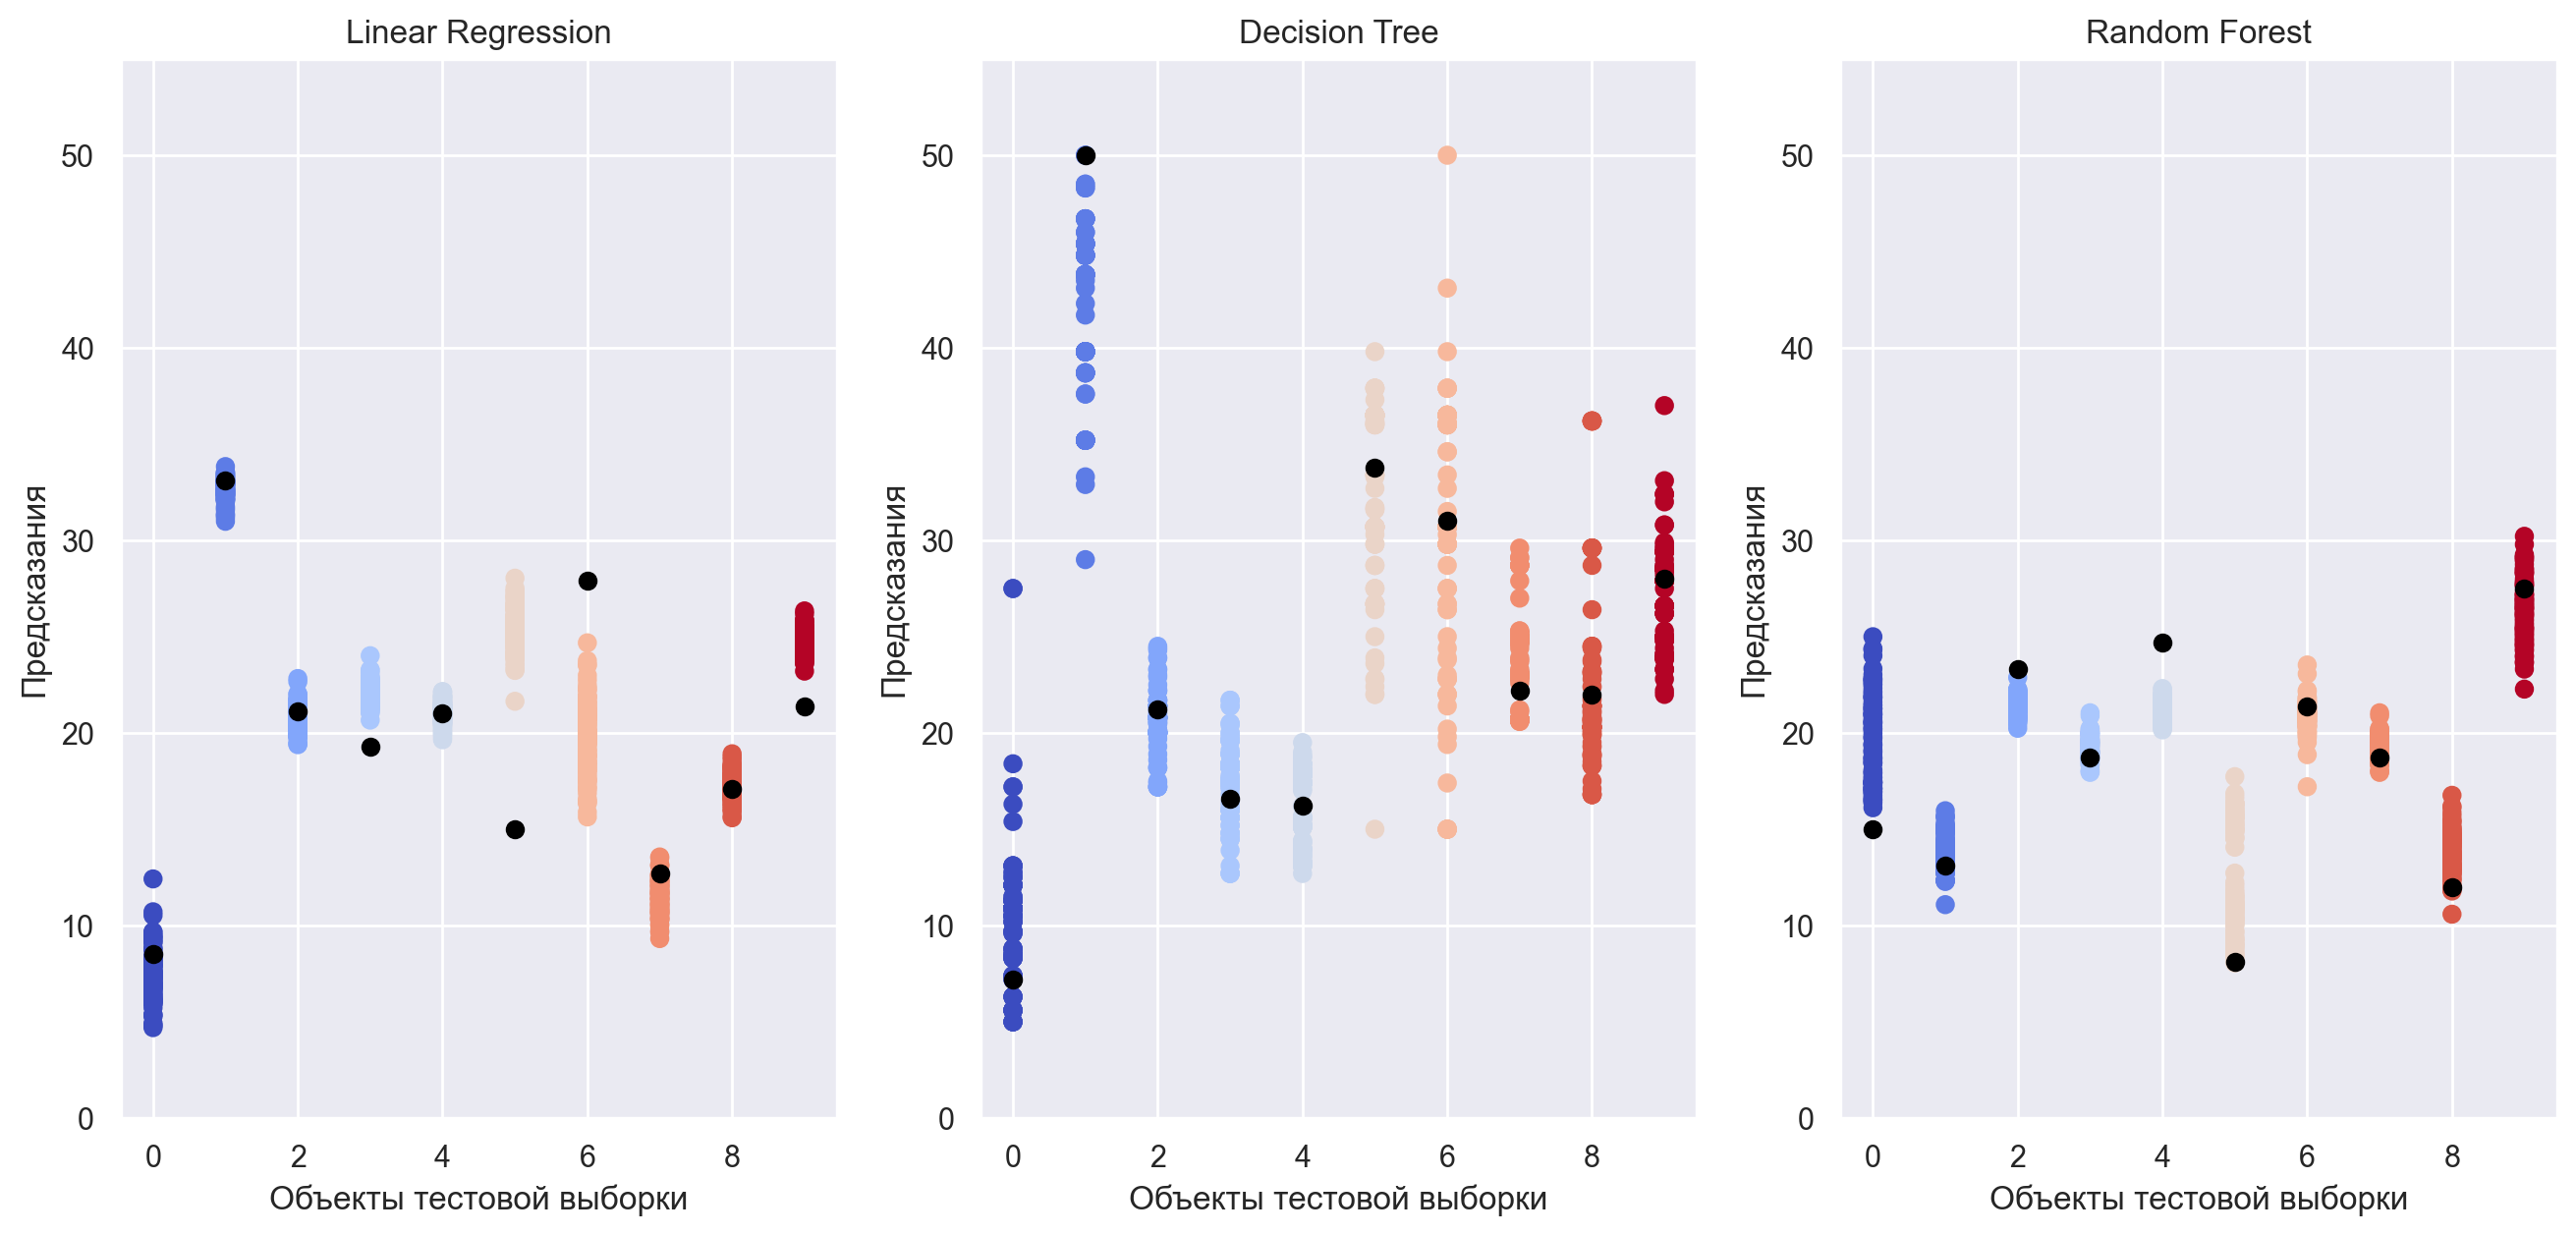

In [55]:
ax1 = plt.subplot(1, 3, 1)
ax1.set_ylim([0, 55])
ax1.figure.set_size_inches(16, 7)
plot_predictions(LinearRegression(), X, y, title = 'Linear Regression', ax = ax1)

ax2 = plt.subplot(1, 3, 2)
ax2.set_ylim([0, 55])
ax2.figure.set_size_inches(16, 7)
plot_predictions(DecisionTreeRegressor(), X, y, title = 'Decision Tree', ax = ax2)

ax3 = plt.subplot(1, 3, 3)
ax3.set_ylim([0, 55])
ax3.figure.set_size_inches(16, 7)
plot_predictions(RandomForestRegressor(), X, y, title = 'Random Forest', ax = ax3)

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Смещение - относительное положение черной точки на отрезке (чем ближе к середине отрезка, тем меньше), разброс - длина отрезка. Мы видим, что:
* У Linear Regression отрезки маленькой длины, что свидетельствует о маленьком разбросе, но при этом черная точка часто бывает с края отрезка, либо вообще выходит за него (говорит о большом смещении). 
* У Decision Tree наоборот, маленькое смещение (часто черная точка поподает в центр) и большой разброс (отрезки длинные).
* У Random Forest не очень большой разброс (отрезки маленькой длины) и маленькое смещение (часто попадаем в центр).

Таким образом, полученные результаты сходятся с ранее полученными значениями разброса и смещения.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [74]:
def plot_biases_variances(model, space, hyperparameter, biases, variances):
    plt.plot(space, variances, label = 'Разброс')
    plt.plot(space, biases, label = 'Смещение')
    plt.title(f'Зависимость смещения и разброса для {model} от гиперпараметра {hyperparameter}')
    plt.ylabel('Значение разброса/смещения')
    plt.xlabel(f'Значение {hyperparameter}')
    plt.legend(title = 'Показатель')
    plt.show()

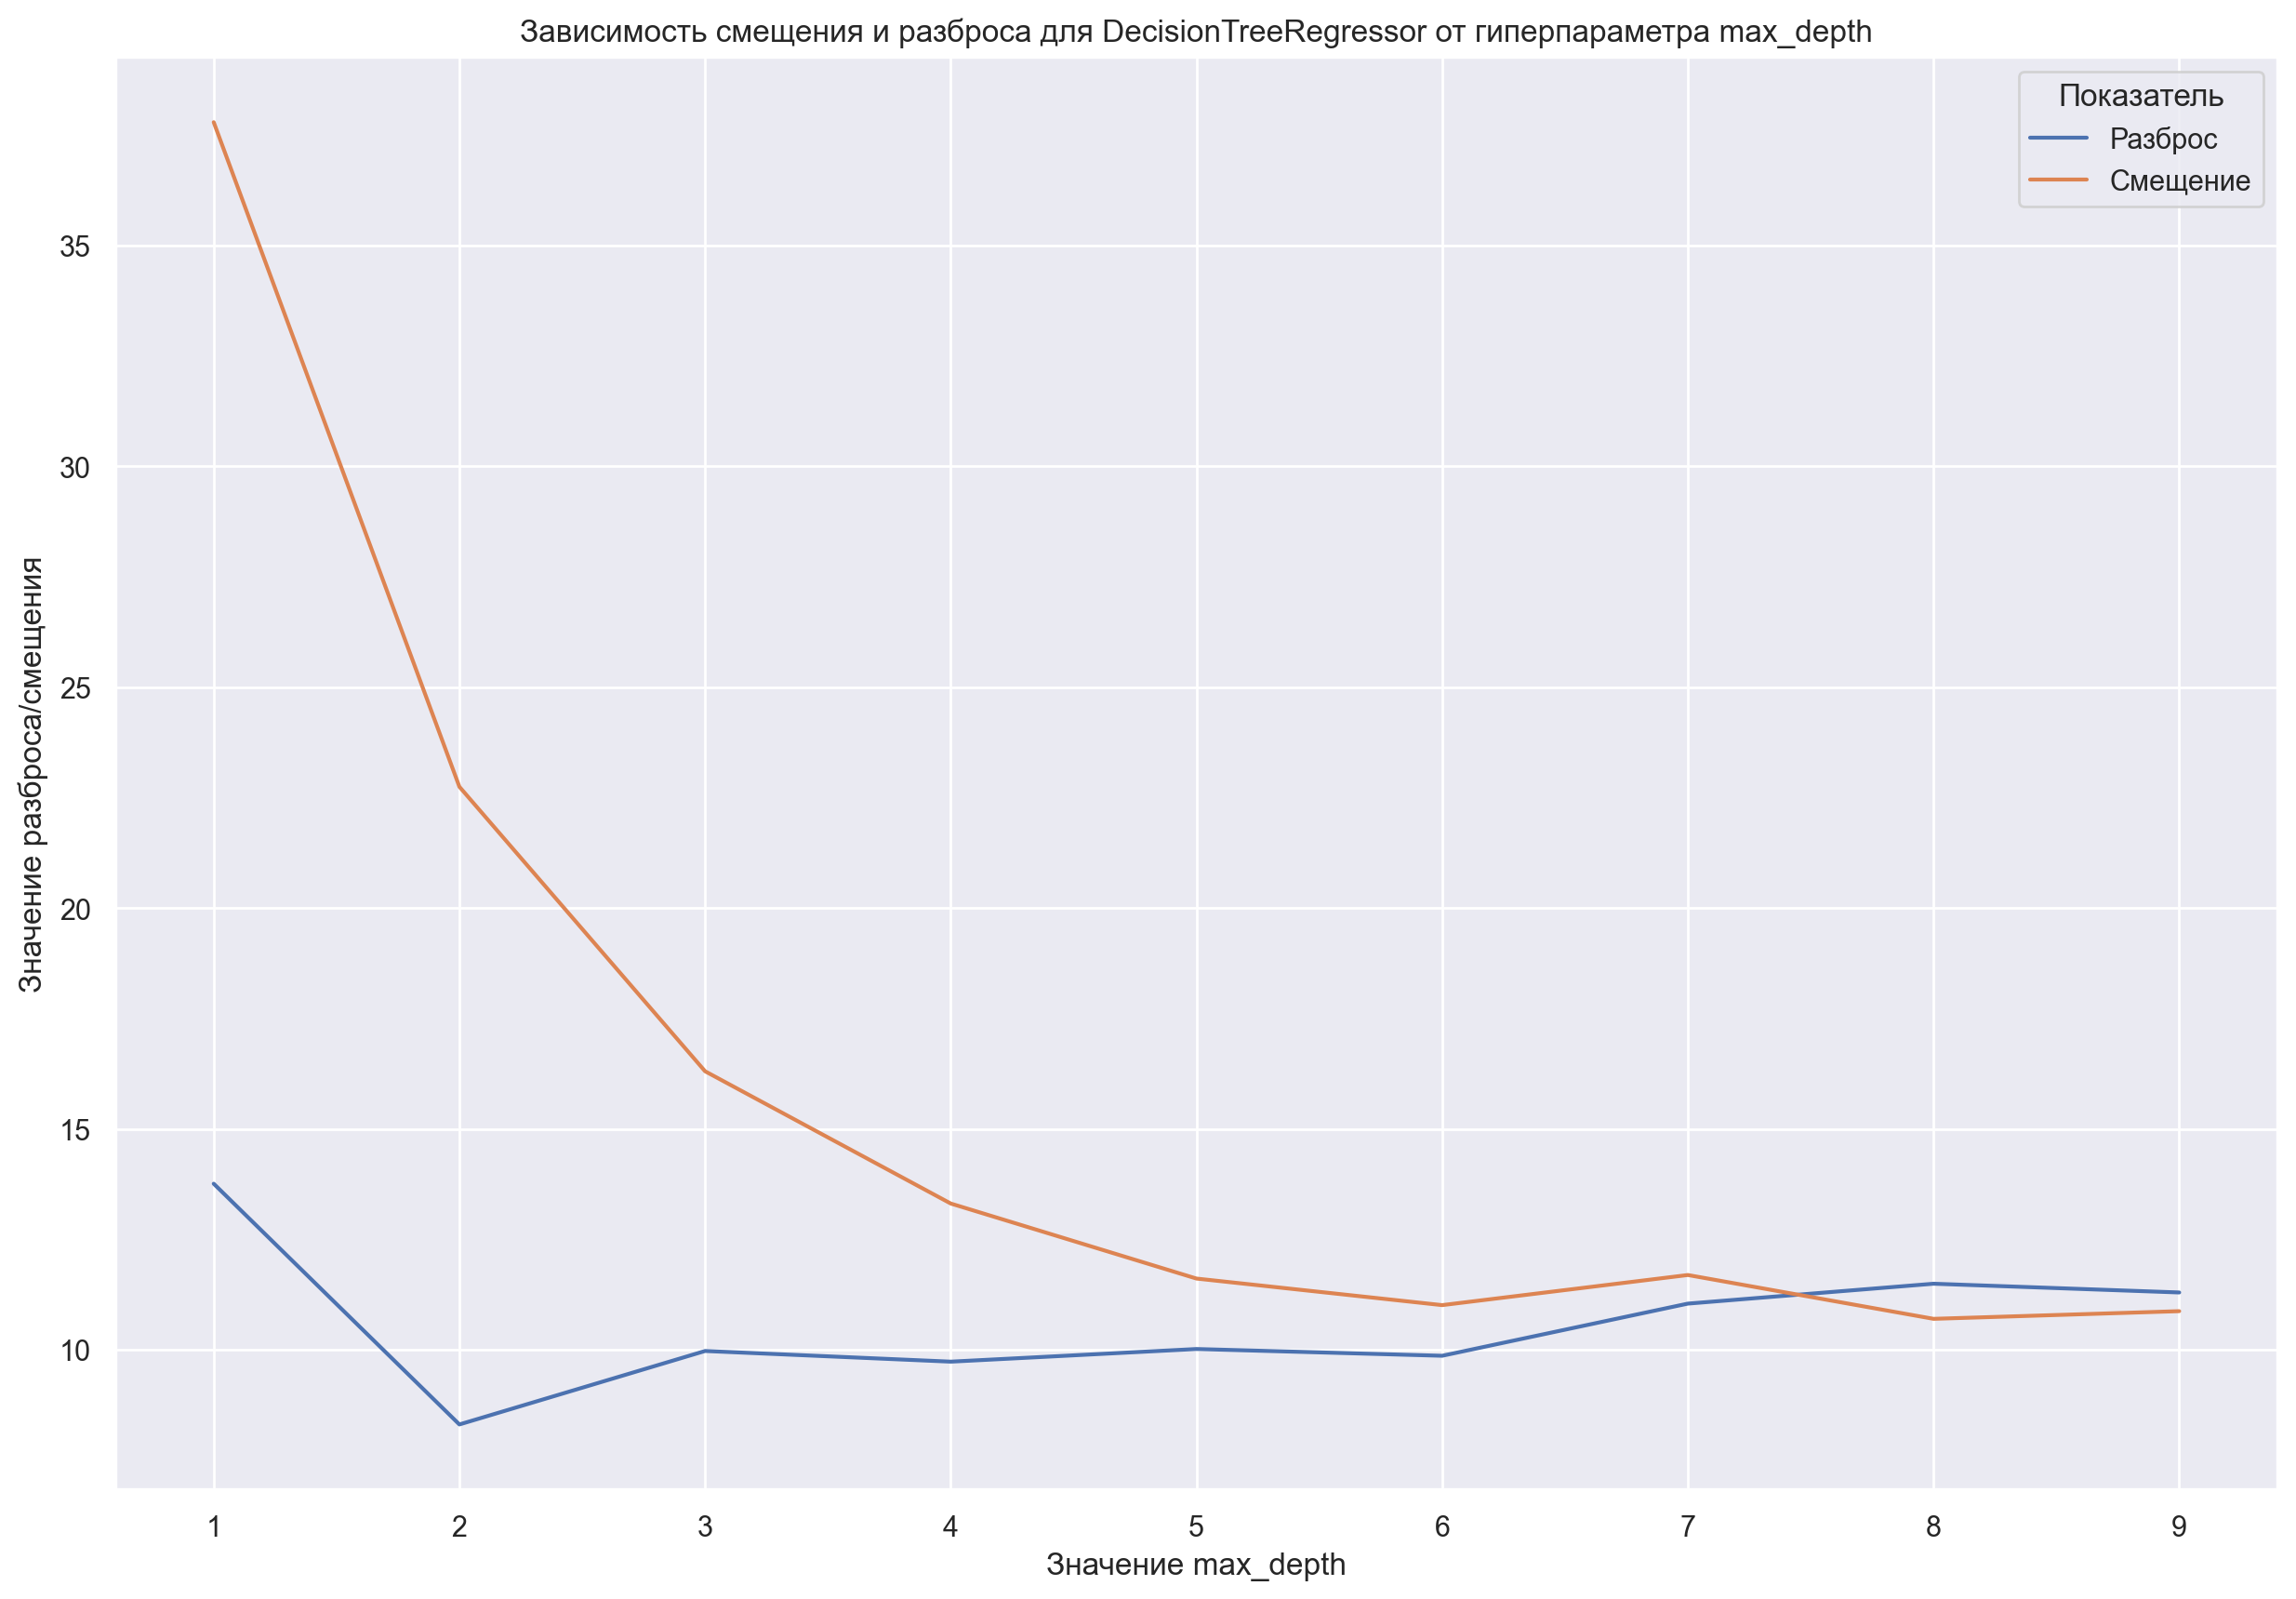

In [75]:
biases = []
variances = []
space = range(1, 10)
for max_depth in space:
    tree = DecisionTreeRegressor(max_depth = max_depth)
    bias, variance, _ = compute_biase_variance(tree, X, y)
    biases.append(bias)
    variances.append(variance)
biases = np.array(biases)
variances = np.array(variances)
plot_biases_variances('DecisionTreeRegressor', space, 'max_depth', biases, variances)

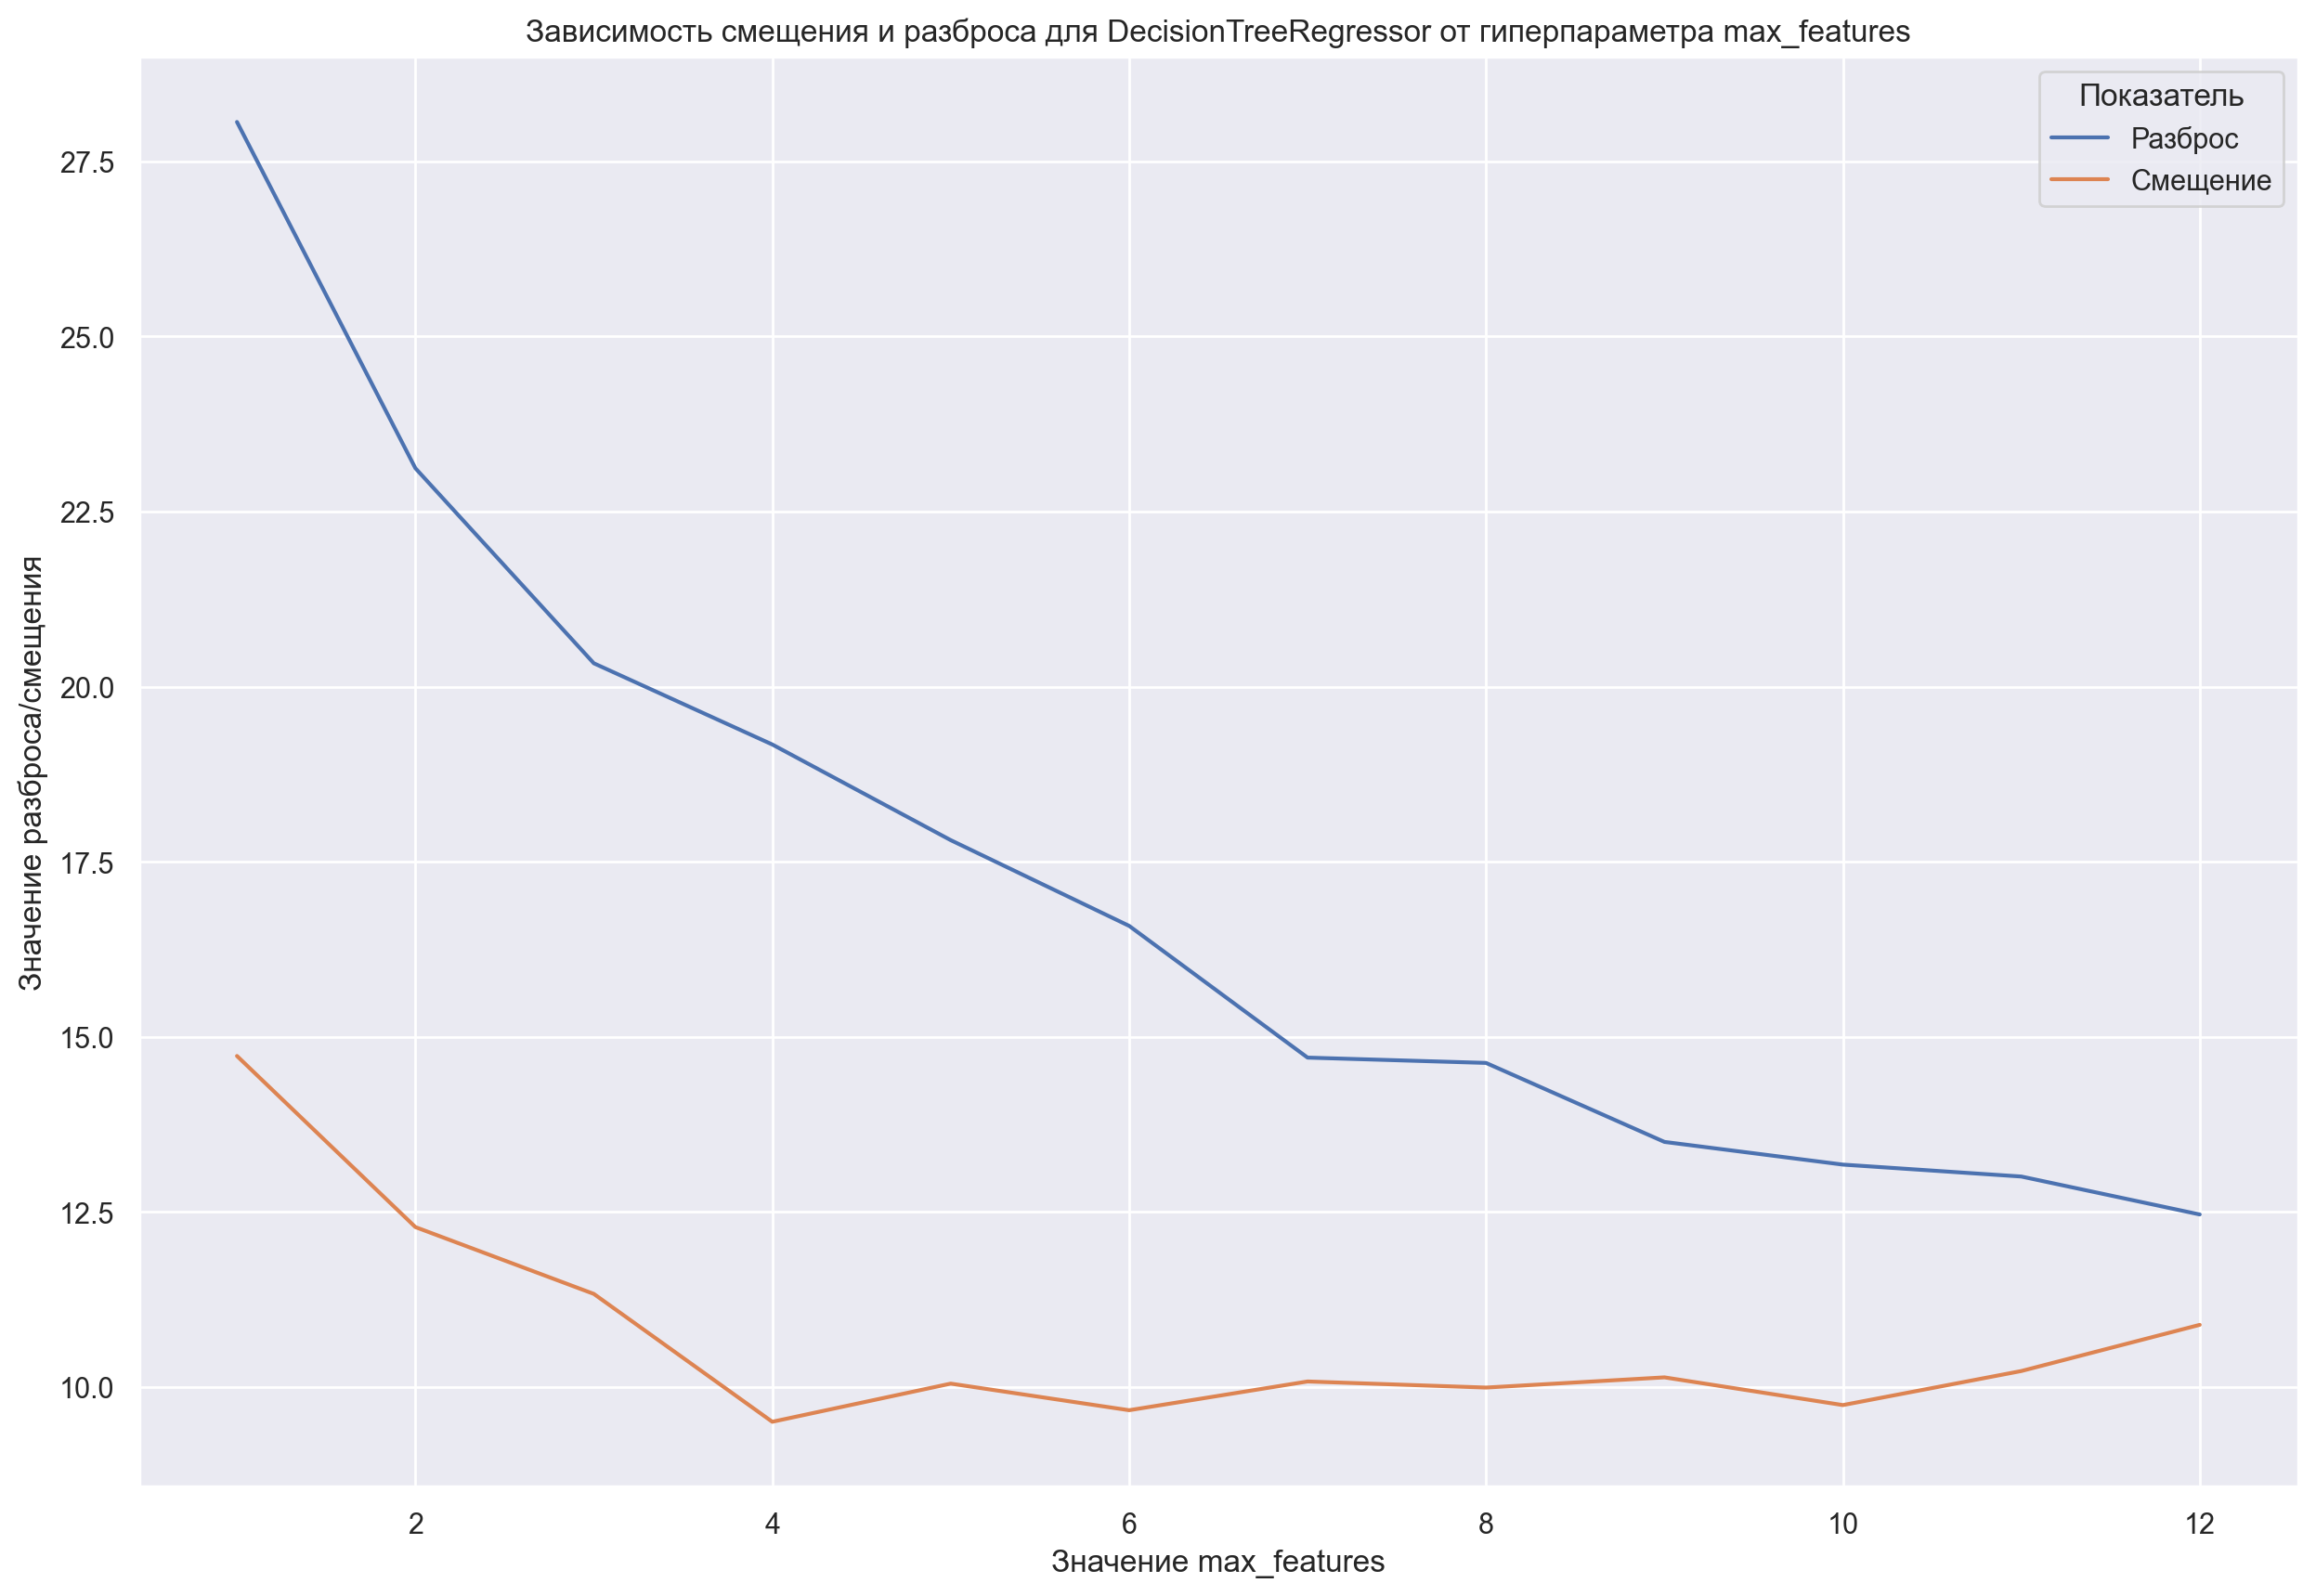

In [76]:
biases = []
variances = []
space = range(1, X.shape[1])
for max_features in space:
    tree = DecisionTreeRegressor(max_features = max_features)
    bias, variance, _ = compute_biase_variance(tree, X, y)
    biases.append(bias)
    variances.append(variance)
biases = np.array(biases)
variances = np.array(variances)
plot_biases_variances('DecisionTreeRegressor', space, 'max_features', biases, variances)

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

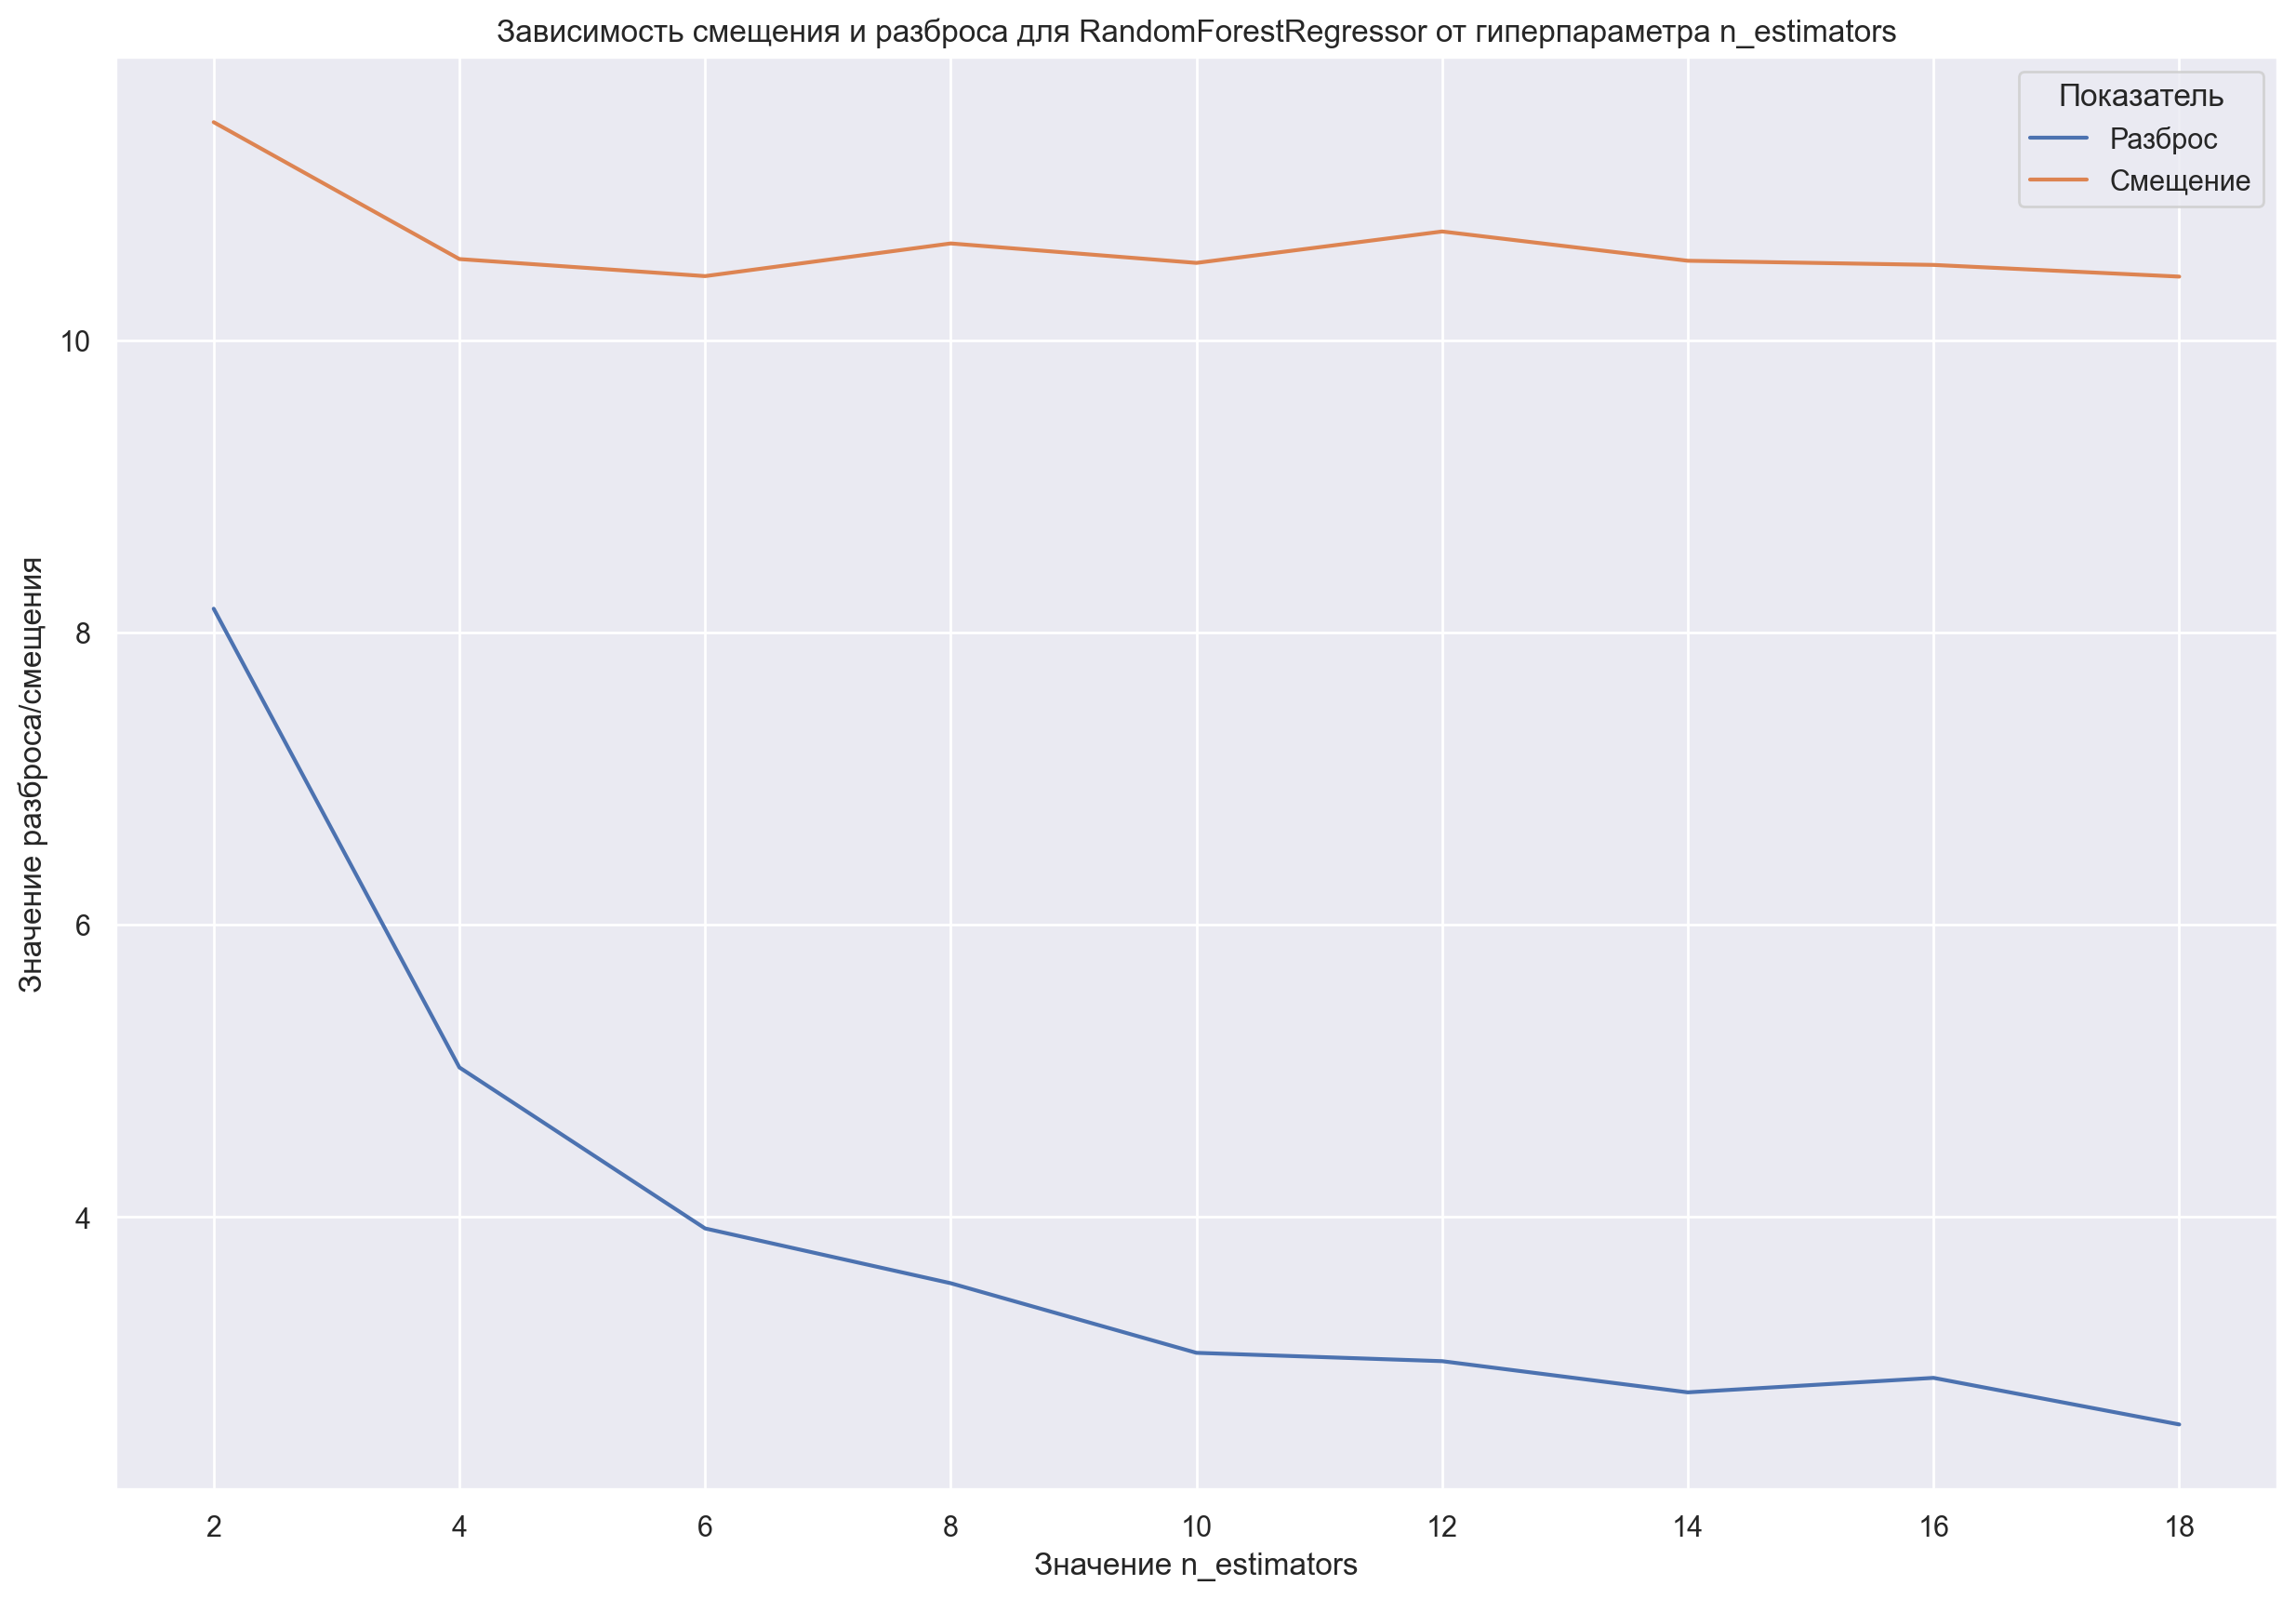

In [77]:
biases = []
variances = []
space = 2 * np.arange(1, 10)
for n_estimators in space:
    regressor = RandomForestRegressor(n_estimators = n_estimators)
    bias, variance, _ = compute_biase_variance(regressor, X, y)
    biases.append(bias)
    variances.append(variance)
biases = np.array(biases)
variances = np.array(variances)
plot_biases_variances('RandomForestRegressor', space, 'n_estimators', biases, variances)

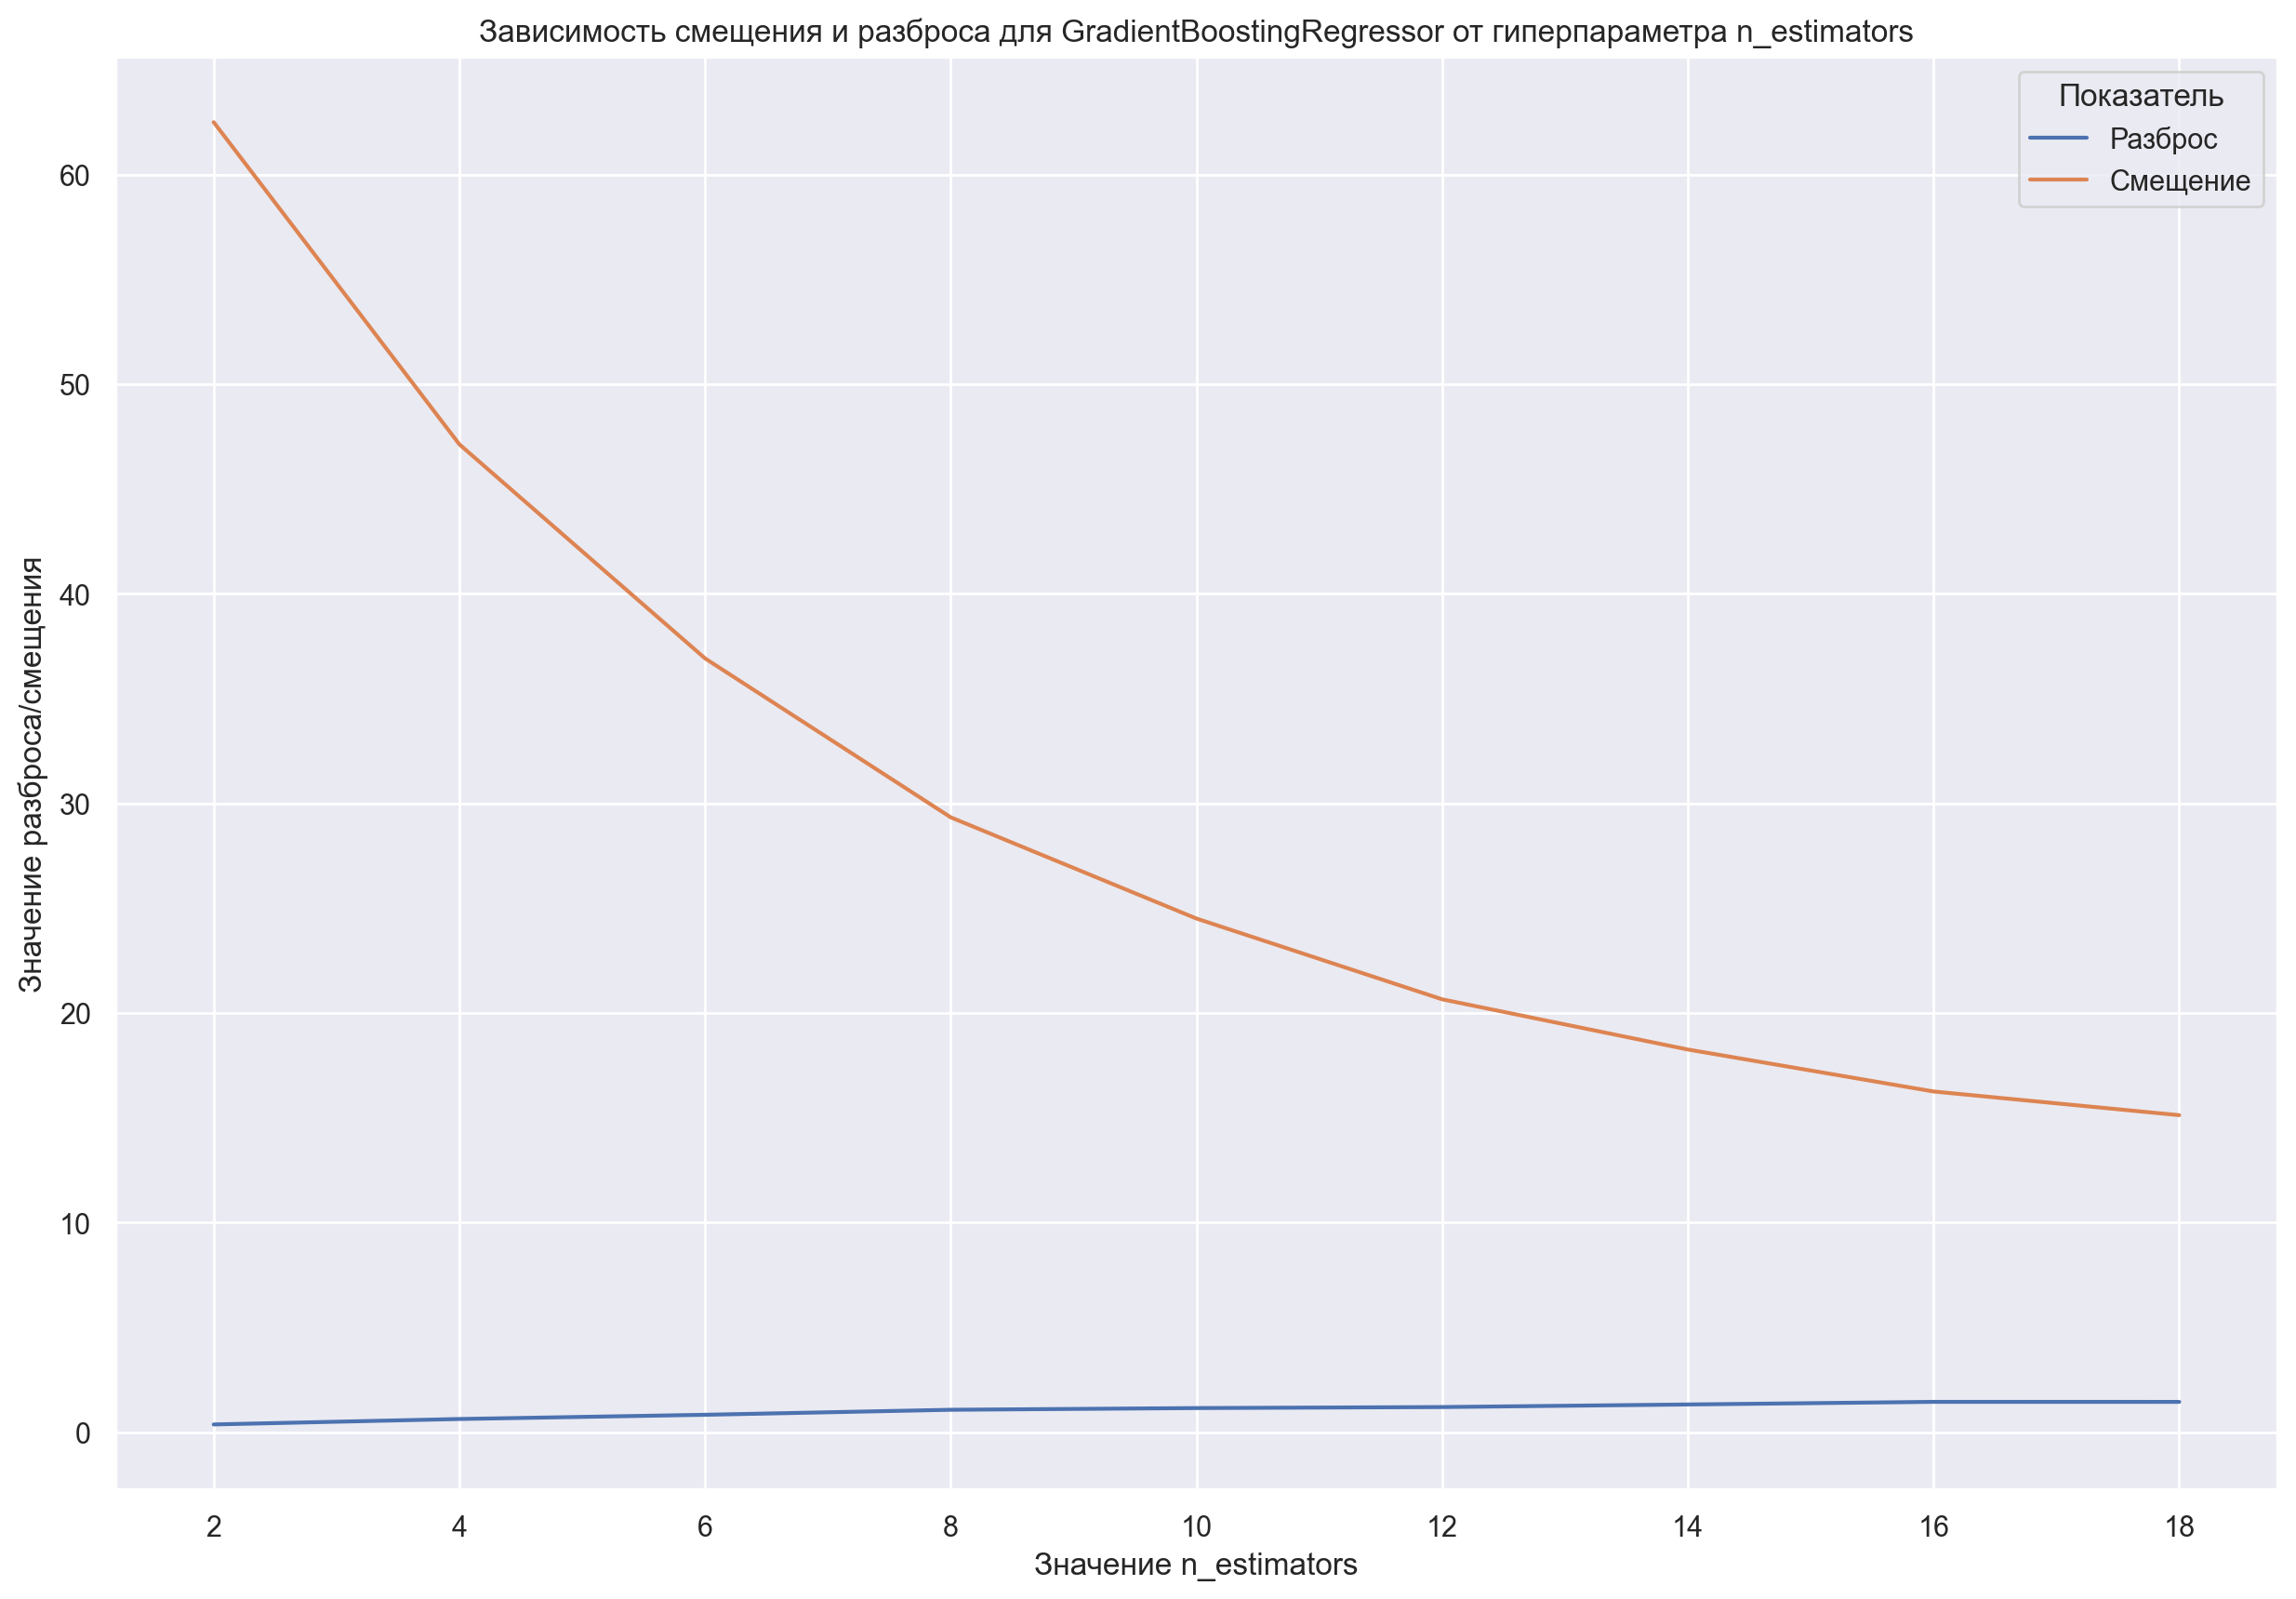

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

biases = []
variances = []
space = 2 * np.arange(1, 10)
for n_estimators in space:
    regressor = GradientBoostingRegressor(n_estimators = n_estimators)
    bias, variance, _ = compute_biase_variance(regressor, X, y)
    biases.append(bias)
    variances.append(variance)
biases = np.array(biases)
variances = np.array(variances)
plot_biases_variances('GradientBoostingRegressor', space, 'n_estimators', biases, variances)

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

**Деревья**:

* **max_depth**: чем меньше max_depth (max_depth > 1), тем больше обобщающая способность, так как мы не строим сложное разбиение под наш трейн (= меньше разброс), но при этом наше дерево становится менее сложным и не подстраивается хорошо под наблюдаемую зависимость в данных (= больше смещение).
* **max_features**: чем больше доступно признаков для сплита, тем лучше сплит мы сможем выбрать. Из-за этого у нас будет меньше смещение. Разброс будет ниже потому, что при больших max_features мы меньше рассчитываем на случайность, так как мы будем стремиться выбирать наиболее информативные признаки.

**Random Forest**: для случайного леса с увеличением количества деревьев уменьшается разброс, потому что лес основан на бэггинге над решающими деревьями. В бэггинге при увеличении количества моделей должен уменьшаться разброс в силу того, что добавленные алгоритмы слабо коррелируют с предыдущими. Смещение на одном и том же уровне, потому что мы всего лишь добавляем еще одну модель со схожим значением смещения => при усреднении этот показатель практически не меняется и сходится к своему среднему.

**Gradient Boosting Machine**: для градиентного бустинга мы знаем, что каждая следующая модель исправляет ошибки предыдущих, поэтому с увеличением количества моделей мы лучше подстраиваемся под трейн, то есть смещение уменьшается. Разброс же растет, но не так сильно, так как мы усложняем наш ансамбль моделей и лучше подстраиваемся под трейн, что уменьшает нашу обобщающую способность.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

Становлюсь скуфом с другом: 

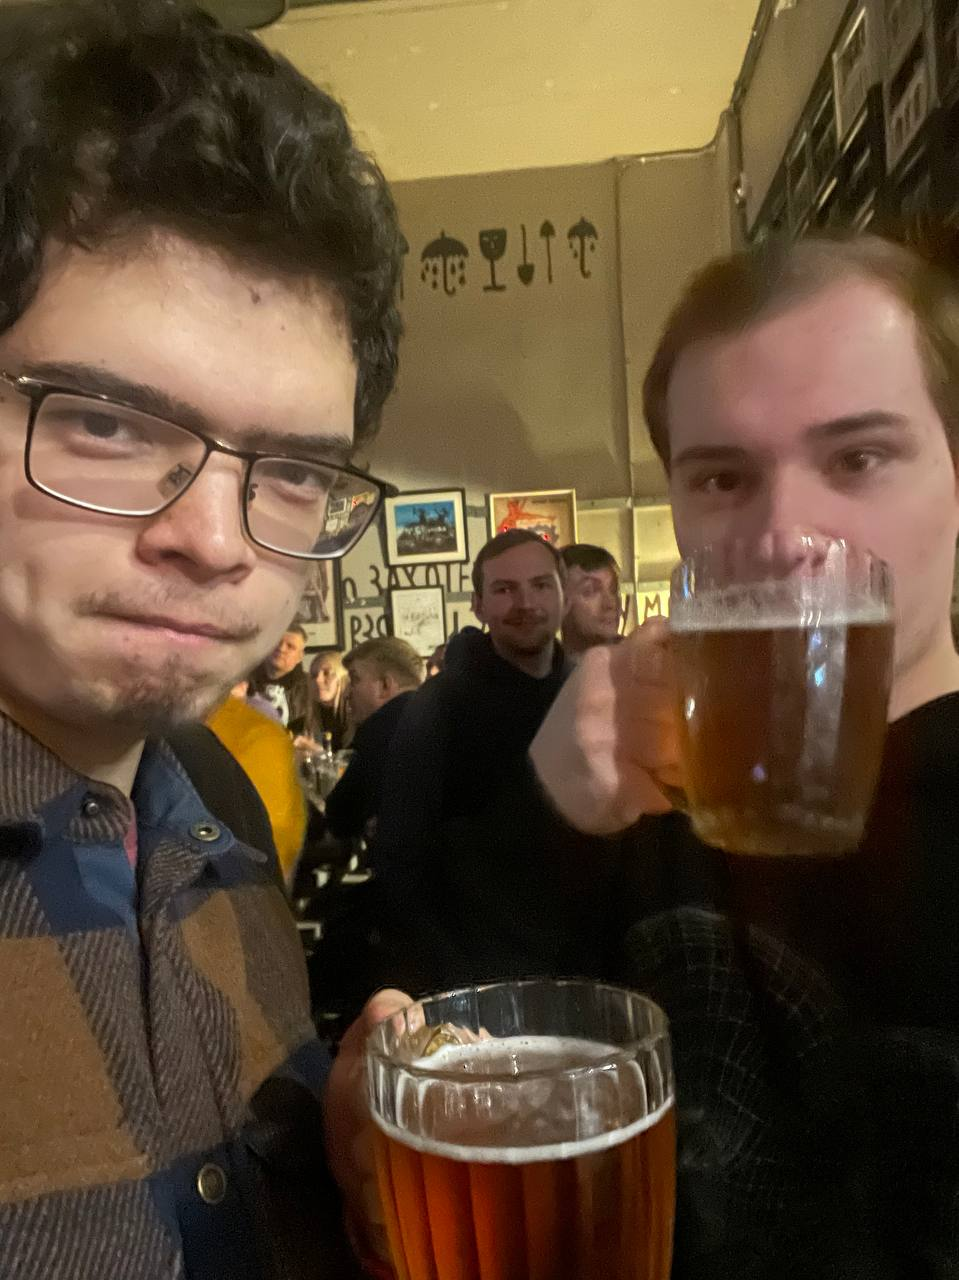